In [2]:
import os
import argparse
import torch
from models.GANF import GANF
import numpy as np
from sklearn.metrics import roc_auc_score

In [3]:
# from data import fetch_dataloaders
parser = argparse.ArgumentParser()
# files
parser.add_argument('--data_dir', type=str, 
                    default='./data/SWaT_Dataset_Attack_v0.csv', help='Location of datasets.')
parser.add_argument('--output_dir', type=str, 
                    default='./checkpoint/model')
parser.add_argument('--name',default='GANF_Water')
# restore
parser.add_argument('--graph', type=str, default='None')
parser.add_argument('--model', type=str, default='None')
parser.add_argument('--seed', type=int, default=18, help='Random seed to use.')
# made parameters
parser.add_argument('--n_blocks', type=int, default=1, help='Number of blocks to stack in a model (MADE in MAF; Coupling+BN in RealNVP).')
parser.add_argument('--n_components', type=int, default=1, help='Number of Gaussian clusters for mixture of gaussians models.')
parser.add_argument('--hidden_size', type=int, default=32, help='Hidden layer size for MADE (and each MADE block in an MAF).')
parser.add_argument('--n_hidden', type=int, default=1, help='Number of hidden layers in each MADE.')
parser.add_argument('--batch_norm', type=bool, default=False)
# training params
parser.add_argument('--batch_size', type=int, default=512)
parser.add_argument('--weight_decay', type=float, default=5e-4)
parser.add_argument('--n_epochs', type=int, default=1)
parser.add_argument('--lr', type=float, default=2e-3, help='Learning rate.')
parser.add_argument('--log_interval', type=int, default=5, help='How often to show loss statistics and save samples.')

parser.add_argument('--h_tol', type=float, default=1e-4)
parser.add_argument('--rho_max', type=float, default=1e16)
parser.add_argument('--max_iter', type=int, default=20)
parser.add_argument('--lambda1', type=float, default=0.0)
parser.add_argument('--rho_init', type=float, default=1.0)
parser.add_argument('--alpha_init', type=float, default=0.0)

args = parser.parse_known_args()[0]
args.cuda = torch.cuda.is_available()
device = torch.device("cuda" if args.cuda else "cpu")


print(args)

Namespace(alpha_init=0.0, batch_norm=False, batch_size=512, cuda=True, data_dir='./data/SWaT_Dataset_Attack_v0.csv', graph='None', h_tol=0.0001, hidden_size=32, lambda1=0.0, log_interval=5, lr=0.002, max_iter=20, model='None', n_blocks=1, n_components=1, n_epochs=1, n_hidden=1, name='GANF_Water', output_dir='./checkpoint/model', rho_init=1.0, rho_max=1e+16, seed=18, weight_decay=0.0005)


In [4]:
import random
import numpy as np
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

In [5]:
print("Loading dataset")
from dataset import load_water

train_loader, val_loader, test_loader, n_sensor = load_water(args.data_dir, \
                                                                args.batch_size)

Loading dataset


/root/zengzihui/ISST/GANF/dataset.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.label[data.label!="Normal"]=1
/root/zengzihui/ISST/GANF/dataset.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.label[data.label=="Normal"]=0


In [6]:
rho = args.rho_init
alpha = args.alpha_init
lambda1 = args.lambda1
h_A_old = np.inf


max_iter = args.max_iter
rho_max = args.rho_max
h_tol = args.h_tol
epoch = 0

# initialize A
if args.graph != 'None':
    init = torch.load(args.graph).to(device).abs()
    print("Load graph from "+args.graph)
else:
    from torch.nn.init import xavier_uniform_
    init = torch.zeros([n_sensor, n_sensor])
    init = xavier_uniform_(init).abs()
    init = init.fill_diagonal_(0.0)
    
A = torch.tensor(init, requires_grad=True, device=device)

/tmp/ipykernel_73518/725152837.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A = torch.tensor(init, requires_grad=True, device=device)


In [7]:
print("GANF n_blocks: ", args.n_blocks, 
"\nGANF input_size: ", 1, 
"\nGANF hidden_size: ", args.hidden_size, 
"\nGANF n_hidden: ", args.n_hidden)

model = GANF(args.n_blocks, 1, args.hidden_size, args.n_hidden, dropout=0.0, batch_norm=args.batch_norm)
model = model.to(device)

if args.model != 'None':
    model.load_state_dict(torch.load(args.model))
    print('Load model from '+args.model)

GANF n_blocks:  1 
GANF input_size:  1 
GANF hidden_size:  32 
GANF n_hidden:  1


In [8]:
print(model)

GANF(
  (rnn): LSTM(1, 32, batch_first=True)
  (gcn): GNN(
    (lin_n): Linear(in_features=32, out_features=32, bias=True)
    (lin_r): Linear(in_features=32, out_features=32, bias=False)
    (lin_2): Linear(in_features=32, out_features=32, bias=True)
  )
  (nf): MAF(
    (net): FlowSequential(
      (0): MADE(
        (net_input): MaskedLinear(in_features=1, out_features=32, bias=True, cond_features=32)
        (net): Sequential(
          (0): Tanh()
          (1): MaskedLinear(in_features=32, out_features=32, bias=True)
          (2): Tanh()
          (3): MaskedLinear(in_features=32, out_features=2, bias=True)
        )
      )
    )
  )
)


In [9]:
from torch.nn.utils import clip_grad_value_
import seaborn as sns
import matplotlib.pyplot as plt
save_path = os.path.join(args.output_dir,args.name)
if not os.path.exists(save_path):
    os.makedirs(save_path)


loss_best = 100

for _ in range(max_iter):

    while rho < rho_max:
        lr = args.lr 
        optimizer = torch.optim.Adam([
            {'params':model.parameters(), 'weight_decay':args.weight_decay},
            {'params': [A]}], lr=lr, weight_decay=0.0)
        
        for _ in range(args.n_epochs):

            # train iteration
            loss_train = []
            epoch += 1
            model.train()

            zihuicnt = 0
            for x in train_loader:
                # print(f"train phase, epoch{epoch}, x_idx: {zihuicnt}, x_shape: {x.shape}")
                # zihuicnt = zihuicnt + 1
                x = x.to(device)

                optimizer.zero_grad()
                loss = -model(x,  A)
                h = torch.trace(torch.matrix_exp( A* A)) - n_sensor
                total_loss = loss + 0.5 * rho * h * h + alpha * h

                total_loss.backward() 
                clip_grad_value_(model.parameters(), 1)
                optimizer.step()
                loss_train.append(loss.item())
                A.data.copy_(torch.clamp(A.data, min=0, max=1))
                
            
            # evaluate iteration
            model.eval()
            loss_val = []
            with torch.no_grad():
                for x in val_loader:

                    x = x.to(device)
                    loss = -model.test(x, A.data).cpu().numpy()
                    loss_val.append(loss)
            loss_val = np.concatenate(loss_val)

            loss_test = []
            with torch.no_grad():
                for x in test_loader:
                    print(f"test phase, epoch{epoch}, x_idx: {zihuicnt}, x_shape: {x.shape}")
                    zihuicnt = zihuicnt + 1
                    x = x.to(device)
                    loss = -model.test(x, A.data).cpu().numpy()
                    loss_test.append(loss)
            loss_test = np.concatenate(loss_test)

            print(loss_val.max(), loss_val.min(), loss_test.max(), loss_test.min())

            loss_val = np.nan_to_num(loss_val)
            loss_test = np.nan_to_num(loss_test)
            y_test = np.asarray(test_loader.dataset.label.values,dtype=int)
            y_pred = loss_test
            roc_val = roc_auc_score(np.asarray(val_loader.dataset.label.values,dtype=int),loss_val)
            roc_test = roc_auc_score(np.asarray(test_loader.dataset.label.values,dtype=int),loss_test)
            print('Epoch: {}, train -log_prob: {:.2f}, test -log_prob: {:.2f}, roc_val: {:.4f}, roc_test: {:.4f} ,h: {}'\
                    .format(epoch, np.mean(loss_train), np.mean(loss_val), roc_val, roc_test, h.item()))
    
        print('rho: {}, alpha {}, h {}'.format(rho, alpha, h.item()))
        print('===========================================')
        torch.save(A.data,os.path.join(save_path, "graph_{}.pt".format(epoch)))
        torch.save(model.state_dict(), os.path.join(save_path, "{}_{}.pt".format(args.name, epoch)))

        del optimizer
        torch.cuda.empty_cache()
        
        if h.item() > 0.5 * h_A_old:
            rho *= 10
        else:
            break


    h_A_old = h.item()
    alpha += rho*h.item()

    if h_A_old <= h_tol or rho >=rho_max:
        break

test phase, epoch1, x_idx: 0, x_shape: torch.Size([512, 44, 60, 1])
test phase, epoch1, x_idx: 1, x_shape: torch.Size([512, 44, 60, 1])
test phase, epoch1, x_idx: 2, x_shape: torch.Size([512, 44, 60, 1])
test phase, epoch1, x_idx: 3, x_shape: torch.Size([512, 44, 60, 1])
test phase, epoch1, x_idx: 4, x_shape: torch.Size([512, 44, 60, 1])
test phase, epoch1, x_idx: 5, x_shape: torch.Size([512, 44, 60, 1])
test phase, epoch1, x_idx: 6, x_shape: torch.Size([512, 44, 60, 1])
test phase, epoch1, x_idx: 7, x_shape: torch.Size([512, 44, 60, 1])
test phase, epoch1, x_idx: 8, x_shape: torch.Size([512, 44, 60, 1])
test phase, epoch1, x_idx: 9, x_shape: torch.Size([512, 44, 60, 1])
test phase, epoch1, x_idx: 10, x_shape: torch.Size([512, 44, 60, 1])
test phase, epoch1, x_idx: 11, x_shape: torch.Size([512, 44, 60, 1])
test phase, epoch1, x_idx: 12, x_shape: torch.Size([512, 44, 60, 1])
test phase, epoch1, x_idx: 13, x_shape: torch.Size([512, 44, 60, 1])
test phase, epoch1, x_idx: 14, x_shape: torc

In [18]:
pd.DataFrame(y_pred).describe()

,0
count,8987.000000
mean,-3.004086
std,0.118665
min,-3.113805
25%,-3.074225
50%,-3.029855
75%,-2.983083
max,-2.243381


array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

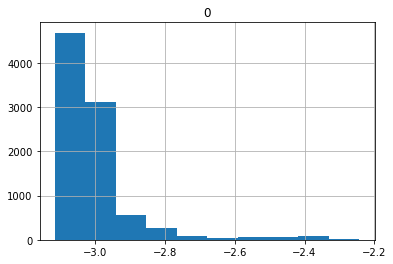

In [19]:
pd.DataFrame(y_pred).hist()

In [20]:
threshold = pd.DataFrame(y_pred).quantile(0.75).values[0] + pd.DataFrame(y_pred).std().values[0]
threshold

-2.864417217671871

In [17]:
# y_test = np.asarray(test_loader.dataset.label.values,dtype=int)
# y_pred = loss_test

print(len(y_test), len(y_pred))

import pandas as pd

# pd.DataFrame(y_pred).hist()
threshold = pd.DataFrame(y_pred).quantile(0.75).values[0] + pd.DataFrame(y_pred).std().values[0]
y_pred_ = np.zeros(y_pred.shape[0])
y_pred_[y_pred >= threshold] = 1

from sklearn.metrics import f1_score, precision_score, recall_score

f1 = f1_score(y_test, y_pred_)
pre = precision_score(y_test, y_pred_)
rec = recall_score(y_test, y_pred_)


print(f"f1_score: {f1} precision: {pre}  recall: {rec}")

8987 8987
f1_score: 0.21145374449339208 precision: 0.18072289156626506  recall: 0.25477707006369427


In [21]:
lr = args.lr 
optimizer = torch.optim.Adam([
    {'params':model.parameters(), 'weight_decay':args.weight_decay},
    {'params': [A]}], lr=lr, weight_decay=0.0)

for _ in range(30):
    loss_train = []
    epoch += 1
    model.train()
    for x in train_loader:
        x = x.to(device)

        optimizer.zero_grad()
        loss = -model(x, A)
        h = torch.trace(torch.matrix_exp(A*A)) - n_sensor
        total_loss = loss + 0.5 * rho * h * h + alpha * h 

        total_loss.backward()
        clip_grad_value_(model.parameters(), 1)
        optimizer.step()
        loss_train.append(loss.item())
        A.data.copy_(torch.clamp(A.data, min=0, max=1))

    # eval 
    model.eval()
    loss_val = []
    with torch.no_grad():
        for x in val_loader:

            x = x.to(device)
            loss = -model.test(x, A.data).cpu().numpy()
            loss_val.append(loss)
    loss_val = np.concatenate(loss_val)

    loss_test = []
    with torch.no_grad():
        for x in test_loader:

            x = x.to(device)
            loss = -model.test(x, A.data).cpu().numpy()
            loss_test.append(loss)
    loss_test = np.concatenate(loss_test)

    loss_val = np.nan_to_num(loss_val)
    loss_test = np.nan_to_num(loss_test)
    y_test = np.asarray(val_loader.dataset.label.values, dtype=int)
    y_pred = loss_test
    roc_val = roc_auc_score(np.asarray(val_loader.dataset.label.values,dtype=int),loss_val)
    roc_test = roc_auc_score(np.asarray(test_loader.dataset.label.values,dtype=int),loss_test)
    print('Epoch: {}, train -log_prob: {:.2f}, test -log_prob: {:.2f}, roc_val: {:.4f}, roc_test: {:.4f} ,h: {}'\
            .format(epoch, np.mean(loss_train), np.mean(loss_val), roc_val, roc_test, h.item()))

    if np.mean(loss_val) < loss_best:
        loss_best = np.mean(loss_val)
        print("save model {} epoch".format(epoch))
        torch.save(A.data,os.path.join(save_path, "graph_best.pt"))
        torch.save(model.state_dict(), os.path.join(save_path, "{}_best.pt".format(args.name)))

    if epoch % args.log_interval==0:
        torch.save(A.data,os.path.join(save_path, "graph_{}.pt".format(epoch)))
        torch.save(model.state_dict(), os.path.join(save_path, "{}_{}.pt".format(args.name, epoch)))

Epoch: 12, train -log_prob: 0.62, test -log_prob: -1.57, roc_val: 0.5934, roc_test: 0.5806 ,h: 0.0005645751953125
save model 12 epoch
Epoch: 13, train -log_prob: -2.01, test -log_prob: -2.05, roc_val: 0.7710, roc_test: 0.7635 ,h: 0.0003509521484375
save model 13 epoch
Epoch: 14, train -log_prob: -2.06, test -log_prob: -2.67, roc_val: 0.8485, roc_test: 0.7788 ,h: 0.00023651123046875
save model 14 epoch
Epoch: 15, train -log_prob: -2.10, test -log_prob: -2.38, roc_val: 0.8251, roc_test: 0.7911 ,h: 0.000164031982421875
Epoch: 16, train -log_prob: -2.11, test -log_prob: -1.83, roc_val: 0.7827, roc_test: 0.7088 ,h: 0.0001220703125
Epoch: 17, train -log_prob: -2.12, test -log_prob: -2.09, roc_val: 0.7766, roc_test: 0.7986 ,h: 0.000102996826171875
Epoch: 18, train -log_prob: -2.14, test -log_prob: -2.71, roc_val: 0.8249, roc_test: 0.7697 ,h: 8.392333984375e-05
save model 18 epoch
Epoch: 19, train -log_prob: -2.16, test -log_prob: -2.42, roc_val: 0.8301, roc_test: 0.7568 ,h: 7.2479248046875e-0

In [23]:
threshold = pd.DataFrame(y_pred).quantile(0.75).values[0] + pd.DataFrame(y_pred).std().values[0]
y_pred_ = np.zeros(y_pred.shape[0])
y_pred_[y_pred <= threshold] = 1

from sklearn.metrics import f1_score, precision_score, recall_score

f1 = f1_score(y_test, y_pred_)
pre = precision_score(y_test, y_pred_)
rec = recall_score(y_test, y_pred_)


print(f"f1_score: {f1} precision: {pre}  recall: {rec}")

f1_score: 0.052039381153305204 precision: 0.026724449259660527  recall: 0.9866666666666667
